# Multiple Variables

In [21]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys

In [22]:
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

Can this be extended to more dimensions, e.g. a wave travelling from left to right? 
What if only some points are observed? Can we infer other points? Now there are correlations, so maybe this isn't the best method.

In [88]:
pyro.clear_param_store()
nx = 21
def wave(guess,plot_wave=False):
    """ what are input params  """
    # basic parameters (fixed)
    nx = 21  # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2 / (nx-1)
    nt = 10    #nt is the number of timesteps we want to calculate
    dt = .025  #dt is the amount of time each timestep covers (delta t)

    # initial conditions
    h = torch.ones(nx)     
    h[int(.5 / dx):int(1 / dx + 1)] = 2  # set h = 2 between 0.5 and 1 
    if (plot_wave):
        plt.plot(np.linspace(0, 2, nx), h.numpy());
    
    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(guess, 0.25))

    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(nx)

    for n in range(nt): 
        hn[0] = h[0]
        hn[1:] = h[1:] - speed * dt / dx * (h[1:] - h[0:-1])
        # set h to hn for next iteration
        h = hn
    
    # the final observed h may have some noise
    #for i in pyro.plate("h_loop",nx): not independent
    # the final observed h may have some noise
    h = torch.tensor([pyro.sample("h_{}".format(str(i)),dist.Normal(h[i],0.01)) 
                      for i in range(nx)])
    if (plot_wave):
        plt.plot(np.linspace(0, 2, nx), h.numpy());

    return(speed,h)


speed = tensor(1.0965) 
h = tensor([0.9923, 1.0134, 0.9931, 1.0019, 0.9970, 1.0417, 1.2070, 1.4362, 1.7049,
        1.8862, 1.9721, 1.9443, 1.8170, 1.5588, 1.2785, 1.1035, 1.0287, 1.0226,
        1.0045, 1.0092, 0.9917])


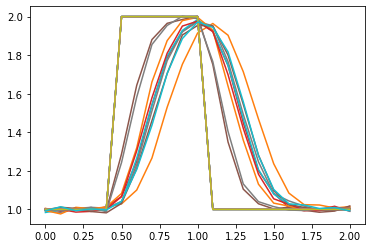

In [89]:
guess = 1.
for i in range(10):
    speed,h=wave(guess,plot_wave=True)
print("speed =",speed,"\nh =",h)

In [90]:
uncond = [wave(guess) for i in range(100)]
speed_uncond,h_uncond = zip(*uncond)

1.0177743


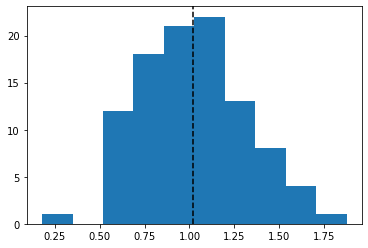

In [91]:
plt.hist(speed_uncond)
plt.axvline(np.mean(speed_uncond),c="k",ls="--")
print(np.mean(speed_uncond))

We observe the wave at a few points around the peak (copy and pasted from an example wave that had speed 0.6828)

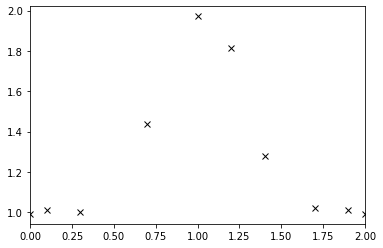

In [92]:
observed_h = [1.7982, 1.8927, 1.9496, 1.9769, 1.9807, 
              1.9590, 1.9026, 1.8027, 1.6616, 1.4969]
observed_inds = range(25,36)

observed_speed = speed
# Pick some random points that we observe
observed_inds = np.random.choice(len(h),size=10,replace=False)
# TEMPORARILY FIX THIS
observed_inds = [3, 20, 14, 10,  1, 17,  7, 12,  0, 19]
observed_h = h[observed_inds]

# Put into data dictionary with named labels
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))

# Plot
plt.plot(np.linspace(0,2,nx)[observed_inds],observed_h.numpy(),'kx');
plt.axis(xmin=0.,xmax=2);

In [93]:
print(observed_inds)

[3, 20, 14, 10, 1, 17, 7, 12, 0, 19]


In [94]:
print(data)

{'h_3': tensor(1.0019), 'h_20': tensor(0.9917), 'h_14': tensor(1.2785), 'h_10': tensor(1.9721), 'h_1': tensor(1.0134), 'h_17': tensor(1.0226), 'h_7': tensor(1.4362), 'h_12': tensor(1.8170), 'h_0': tensor(0.9923), 'h_19': tensor(1.0092)}


In [95]:
observed_speed

tensor(1.0965)

In [96]:
conditioned_wave = pyro.condition(wave, data=data)

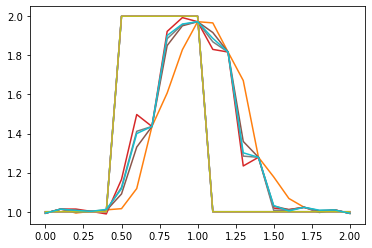

In [97]:
# Check this gives conditioned values fixed
for i in range(5):
    u_observed = conditioned_wave(guess,plot_wave=True)

What if we condition on wave output, can we get the wave speed needed to get this output (using fixed wave speed from before, the correct value should be 0.5)?

Now create the guide, with parameters that should move us towards observed values of the wave.

In [98]:
from torch.distributions import constraints

def wave_parametrized_guide(guess,plot_wave=False):
    nx = 21  
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), 
                   constraint=constraints.positive)

    speed = pyro.sample("speed", dist.Normal(a,b))
    h = torch.zeros(nx)
    
    # TEMPORARILY FIX OBSERVED INDICES
    #observed_inds = [3, 20, 14, 10,  1, 17,  7, 12,  0, 19]

    for i in range(nx):
        # TEMP
        if (i in observed_inds):
            continue
        # Need to sample from variables we don't have observations for
        # This is probably the worst way to do it- just sampling at random from
        # A normal distribution and then constraining parameters. We could add
        # something that learns from the observartions we do have (eg GP) to do this
        
        c_i = pyro.param("c_{}".format(i),torch.tensor(1.))
        d_i = pyro.param("d_{}".format(i), torch.tensor(1.),
                         constraint=constraints.positive)

        h[i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(c_i,d_i)) )
    
    if plot_wave:
        h = torch.detach(h)
        plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    return(speed,h)



['a', 'b', 'c_2', 'd_2', 'c_4', 'd_4', 'c_5', 'd_5', 'c_6', 'd_6', 'c_8', 'd_8', 'c_9', 'd_9', 'c_11', 'd_11', 'c_13', 'd_13', 'c_15', 'd_15', 'c_16', 'd_16', 'c_18', 'd_18']


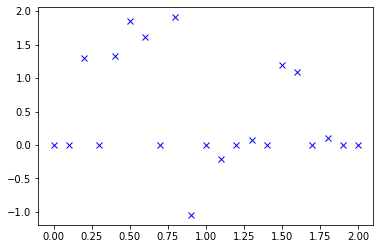

In [34]:
pyro.clear_param_store()
guess=1.
wave_parametrized_guide(guess,plot_wave=True)
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)

(tensor(-0.0443, grad_fn=<AddBackward0>),
 tensor([ 0.0000,  0.0000, -0.0414,  0.0000,  0.2771,  2.6360, -0.9038,  0.0000,
          1.2024, -1.2258,  0.0000,  2.2316,  0.0000, -0.8822,  0.0000,  0.0299,
          0.9354,  0.0000,  0.8341,  0.0000,  0.0000]))

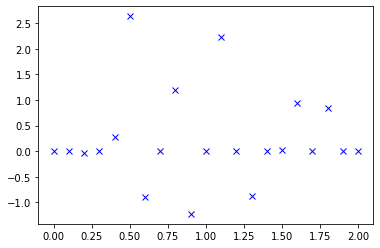

In [35]:
#pyro.clear_param_store()
wave_parametrized_guide(guess,plot_wave=True)

In [36]:
import pyro.poutine
traced=pyro.poutine.trace(wave_parametrized_guide)

In [37]:
param_names = list(pyro.get_param_store().get_all_param_names())

In [38]:
print(param_names)
print(len(param_names))

['a', 'b', 'c_2', 'd_2', 'c_4', 'd_4', 'c_5', 'd_5', 'c_6', 'd_6', 'c_8', 'd_8', 'c_9', 'd_9', 'c_11', 'd_11', 'c_13', 'd_13', 'c_15', 'd_15', 'c_16', 'd_16', 'c_18', 'd_18']
24


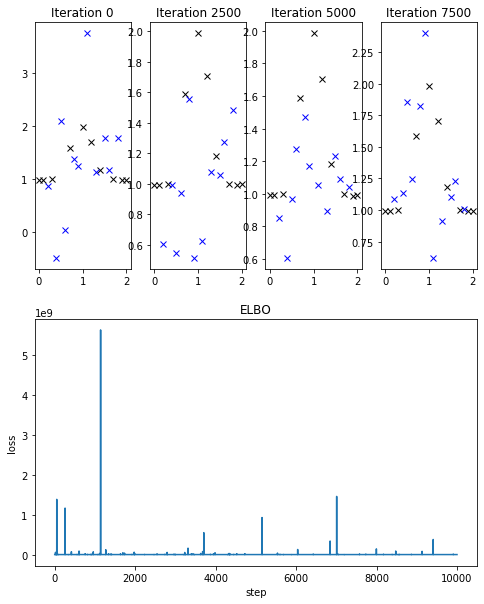

In [87]:
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_wave, 
                     guide=wave_parametrized_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 10000
# Save all parameters and losses
params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)
fig = plt.figure(figsize=(10,10))

plot_ind = 0
for t in range(num_steps):
    losses[t] = (svi.step(guess=1.))
    params[t,:] = [pyro.param(param_names[i]).item() for i in range(len(param_names))]
    
    if (t%(num_steps/4)==0.):
        ax = plt.subplot2grid((2, 5), (0, plot_ind));
        speed,h=wave_parametrized_guide(guess)
        ax.plot(np.linspace(0,2,nx)[observed_inds],
         observed_h.numpy(),'kx');
        not_observed_inds = [i for i in range(nx) 
                     if i not in observed_inds]
        ax.plot(np.linspace(0,2,nx)[not_observed_inds],
         h.detach().numpy()[not_observed_inds],'bx');
        plot_ind = plot_ind+1
        plt.title('Iteration {}'.format(str(t)))



ax = plt.subplot2grid((2,5), (1, 0), colspan=4);
ax.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");


In [ ]:
print("a = ",pyro.param("a").item())
print("b = ", pyro.param("b").item())

fig = plt.figure()
ax1 = plt.subplot2grid((4, 1), (0, 0));
for i in range(nx):
    ax1.plot(params[:,0])
plt.title('a');

ax2 = plt.subplot2grid((4, 1), (1, 0));
for i in range(nx):
    ax2.plot(params[:,1])
plt.title('b');

ax3 = plt.subplot2grid((4, 1), (2, 0));
for i in range(nx):
    ax3.plot(params[:,2:(nx+2)])
plt.title('c');

ax4 = plt.subplot2grid((4, 1), (3, 0));
for i in range(nx):
    ax4.plot(params[:,(nx+2):])
plt.title('d');
plt.tight_layout();

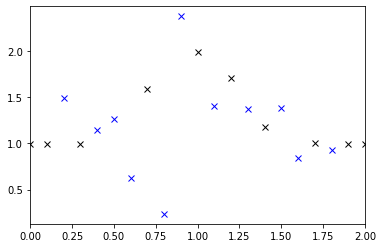

In [50]:
speed,h=wave_parametrized_guide(guess)
plt.plot(np.linspace(0,2,nx)[observed_inds],
         observed_h.numpy(),'kx');
not_observed_inds = [i for i in range(nx) 
                     if i not in observed_inds]
plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         h.detach().numpy()[not_observed_inds],'bx');
plt.axis(xmin=0.,xmax=2);

In [51]:
param_store = pyro.get_param_store()
print(param_store.keys())
print(param_store['a'])
print(param_store['b'])

dict_keys(['a', 'b', 'c_2', 'd_2', 'c_4', 'd_4', 'c_5', 'd_5', 'c_6', 'd_6', 'c_8', 'd_8', 'c_9', 'd_9', 'c_11', 'd_11', 'c_13', 'd_13', 'c_15', 'd_15', 'c_16', 'd_16', 'c_18', 'd_18'])
tensor(1.1073, requires_grad=True)
tensor(0.9034, grad_fn=<AddBackward0>)


In [45]:
observed_speed

tensor(0.9330)

In [47]:
speed,h=wave_parametrized_guide(guess)